# DSHARP opacities (RADMC-3D)
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  04/07/2024          |
| Updated |  04/07/2024          |

## Problem Setup

See [Desmos](https://www.desmos.com/) for interactive plots of 
- [$T = P/\rho$](https://www.desmos.com/calculator/ptyevuziu7)
- [$\rho_\mathrm{mid}$](https://www.desmos.com/calculator/ubtsqj1ltb)
- [$\rho(\theta)$](https://www.desmos.com/calculator/marlugmhhr)

In code units,
\begin{align*}
  T(r, \theta) &= \frac{P(r, \theta)}{\rho} = \frac{P_0}{\rho_0}\left(\frac{r\sin\theta}{r_0}\right)^{-1/2} \\
  \rho_\mathrm{mid}(r) &= \frac{\rho_0\left(\frac{r + r_0}{r_0}\right)^{-9/4}}{1 + \exp\left[-\mathrm{e}^\mathrm{e}\left(\frac{r - r_0}{r_0}\right)\right]} \\
  \rho(r, \theta) &= \rho_\mathrm{mid}\exp\left[\frac{GMr}{P}\left(\frac{1}{\sqrt{r^2\sin^2\theta + r^2\cos^2\theta}} - \frac{1}{r\sin\theta}\right)\right] \\
                  &= \rho_\mathrm{mid}\exp\left[\frac{GM}{P}\left(1 - \frac{1}{\sin\theta}\right)\right] \\
\end{align*}

Let $u_\mathrm{init}$ be the initial specific internal energy of the gas.
From the [classical ideal gas law](https://en.wikipedia.org/wiki/Equation_of_state#Classical_ideal_gas_law), in code units,

\begin{align*}
  T_\mathrm{init} &=  (\gamma - 1)u_\mathrm{init} \\
  u_\mathrm{init} &= \frac{P}{\rho(\gamma - 1)}
\end{align*}

[Text(0.5, 0, '$r$/au'),
 Text(0, 0.5, '$\\rho_\\mathrm{mid}$/($10^{-15}$g cm$^{-3}$)'),
 None,
 None,
 Text(0.5, 1.0, 'problem_setup.py > dust_density.inp')]

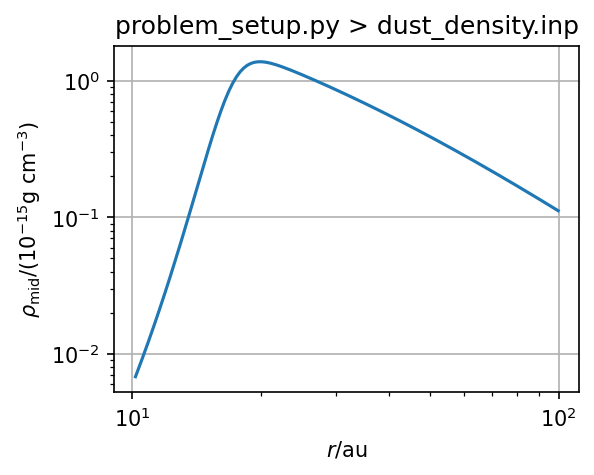

In [1]:
#===============================================================================
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

# BEGIN `amr_grid.inp`==========================================================
# Constants
au       = 1.495978707e13                     # Astronomical Unit       [cm]

# Grid parameters
nr       = 256
ntheta   = 512
nphi     = 1
rin      = 10*au                              # [cm]
rout     = 100*au                             # [cm]
thetamin = 0
thetamax = np.pi
phimin   = 0
phimax   = 2*np.pi

# Make the coordinates
ri       = np.linspace(rin, rout, nr+1)
thetai   = np.linspace(thetamin, thetamax, ntheta+1)
phii     = np.linspace(phimin, phimax, nphi+1)
# END `amr_grid.inp`============================================================


# BEGIN `dust_density.inp`======================================================
# Make the cell-centered grid
rc       = 0.5*(ri[0:nr] + ri[1:nr+1])
thetac   = 0.5*(thetai[0:ntheta] + thetai[1:ntheta+1])
phic     = 0.5*(phii[0:nphi] + phii[1:nphi+1])
qq       = np.meshgrid(rc, thetac, indexing='ij')
rr       = qq[0]
tt       = qq[1]
# zr       = np.pi/2.e0 - qq[1]

# Disk parameters
gm0      = 1.0                                # GM
T_unit   = 6.14e3                             # T_0 [K]
density_unit = 4.28e-14                       # \rho_0 [g/cm^3]
length_unit = 5.98e14                         # L_0 [cm]
dfloor   = 1e-12                              # minimum density [g/cm^3]
r0       = 0.425278227742474                  # disk radial normalization [L_0]
rho0     = 0.2                                # disk density normalization [\rho_0]
p0_over_r0 = 4.80e-03                         # (H/r0)^2
pslope   = -0.5                               # pressure power-law index
dslope   = -2.25                              # density power-law index

# Make the dust density model
def GetCylCoord(x1, x2, x3):
    rad = np.abs(x1*np.sin(x2))
    phi = x3
    z = x1*np.cos(x2)
    return rad, phi, z

def DenProfileCyl(rad, phi, z):
    p_over_r = PoverR(rad, phi, z)
    denmid = rho0*np.power((rad + r0)/r0, dslope)\
            /(1 + np.exp(-np.exp(np.e)*(rad - r0)/r0))
    dentem = denmid*np.exp(gm0/p_over_r*(1./np.sqrt(rad**2 + z**2) - 1./rad))
    den = dentem
    return den

def PoverR(rad, phi, z):
    poverr = p0_over_r0*np.power(rad/r0, pslope)
    return poverr

rads, phis, zs = GetCylCoord(rr/length_unit, tt, 0)
rhod     = DenProfileCyl(rads, phis, zs)
rhod[rhod < dfloor] = dfloor
rhod     = rhod*density_unit

# Plot to compare with theoretical/Athena++ models
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
dtheta = (thetamax - thetamin)/ntheta
theta_mid_deg = 90
rad2deg  = 180/np.pi
j_mid = int(theta_mid_deg/rad2deg/dtheta)

ax.plot(rr[:, j_mid]/au, rhod[:, j_mid]/1e-15)
ax.grid()
ax.minorticks_on()
ax.set(xlabel=r'$r$/au', ylabel=r'$\rho_\mathrm{mid}$/($10^{-15}$g cm$^{-3}$)',
       xscale='log', yscale='log', title='problem_setup.py > dust_density.inp')

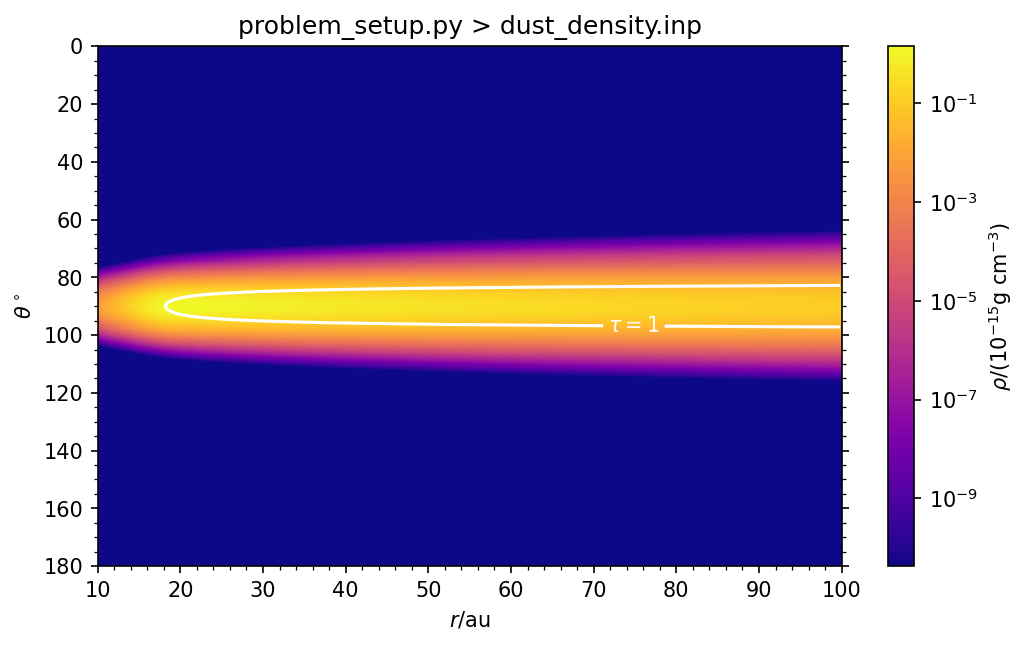

In [2]:
# Plot to compare with theoretical/Athena++ models
def fmt(x):
    return rf'$\tau={x:.0f}$'

kappa_star_cgs = 10                           # [cm^2/g]
dgratio  = 100                                # dust-to-gas ratio
small_grain_ratio = 0.02184
kappa_a  = kappa_star_cgs*dgratio*small_grain_ratio # absorption opacity

fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)
im = ax.pcolormesh(rr/au, tt*rad2deg, rhod/1e-15, cmap='plasma',
                   norm=colors.LogNorm())
dr = (rout - rin)/nr
dtau = rhod*kappa_a*dr
tau  = np.cumsum(dtau, axis=0)
CS = ax.contour(rr/au, tt*rad2deg, tau, [1, 1e4], colors=['white', 'white'])

plt.colorbar(im, label=r'$\rho$/($10^{-15}$g cm$^{-3}$)')
ax.clabel(CS, CS.levels, fmt=fmt)
ax.invert_yaxis()
ax.minorticks_on()
ax.set(xlabel='$r$/au', ylabel=r'$\theta^\circ$',
       title='problem_setup.py > dust_density.inp')
ax.tick_params(axis='both', which='both', right=True)

## Output Analysis

### DSHARP Opacities

- Birnstiel et al. ([2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..45B/abstract))
- (From Shangjia Zhang)
  - 30% water
  - Carbon?

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Reading dustkappa_dsharp.inp


[None,
 None,
 Text(0.5, 0, '$\\mathrm{\\lambda}$ ($\\mathrm{\\mu}$m)'),
 Text(0, 0.5, '$\\kappa_\\nu$ (cm$^2$ g$^{-1}$)'),
 Text(0.5, 1.0, 'DSHARP ($a_\\mathrm{max}=1\\,\\mathrm{\\mu m}, q=3.5$)')]

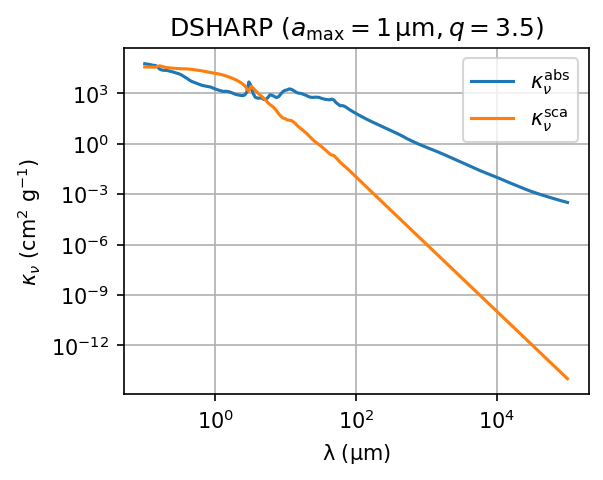

In [3]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import analyze # execute cell twice
from radmc3dPy.natconst import *

# Plot absorption coefficient as a function of wavelength
opac   = analyze.readOpac(ext=['dsharp']) #https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_rmcpy/radmc3dPy.html?highlight=radmc3ddustopac#radmc3dPy.dustopac.radmc3dDustOpac
figsize = (4, 3)
# figsize = (8, 4.5)
fig, ax = plt.subplots(figsize=figsize, dpi=150)

ax.plot(opac.wav[0], opac.kabs[0], label=r'$\kappa_\nu^\mathrm{abs}$')
ax.plot(opac.wav[0], opac.ksca[0], label=r'$\kappa_\nu^\mathrm{sca}$')
ax.grid()
ax.legend()
ax.minorticks_on()
ax.set(xscale='log', yscale='log', xlabel=r'$\mathrm{\lambda}$ ($\mathrm{\mu}$m)',
       ylabel=r'$\kappa_\nu$ (cm$^2$ g$^{-1}$)',
       title=r'DSHARP ($a_\mathrm{max}=1\,\mathrm{\mu m}, q=3.5$)')

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


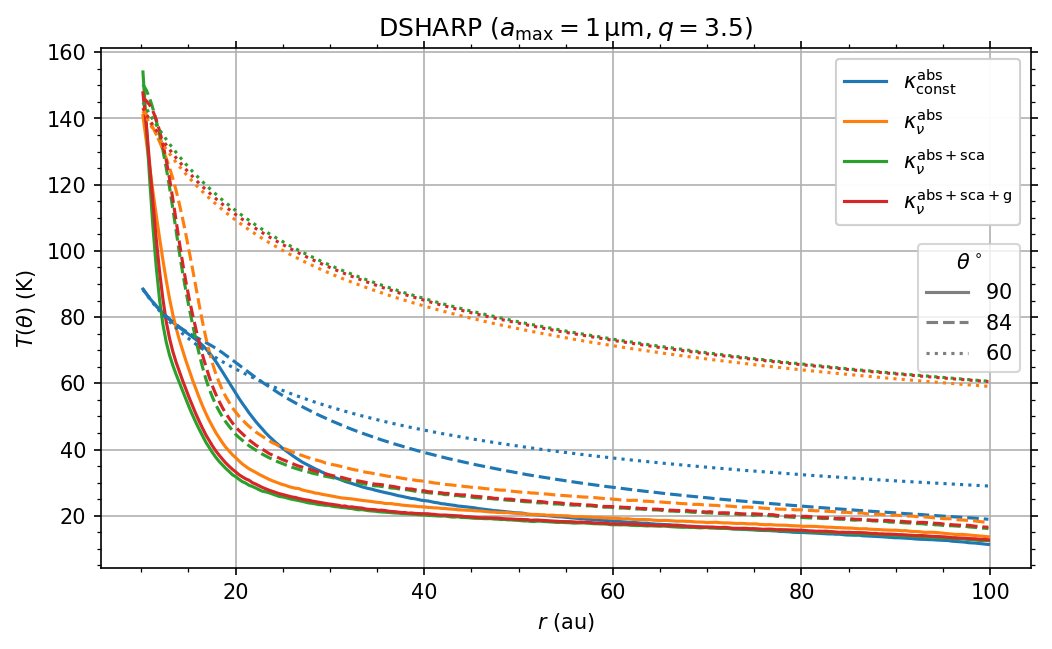

In [19]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions
rad2deg = 180/np.pi # [deg]

# Set up plots
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)
tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 84, 60]
c_solns, ls_thetas = [], []

# Read and plot RADMC-3D solutions
const = np.load('dust_temperature_const.npz')
k_abs = np.load('dust_temperature_abs.npz')
k_abs_sca = np.load('dust_temperature_abs-sca.npz')
data = analyze.readData(ddens=True, dtemp=True)
dtheta = (data.grid.yi[-1] - data.grid.yi[0])/data.grid.ny

for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(data.grid.x/natconst.au, const['dusttemp'][:,j,0,0], 'tab:blue',
            ls=lss[th])
    ax.plot(data.grid.x/natconst.au, k_abs['dusttemp'][:,j,0,0], 'tab:orange',
            ls=lss[th])
    ax.plot(data.grid.x/natconst.au, k_abs_sca['dusttemp'][:,j,0,0], 'tab:green',
            ls=lss[th])
    ax.plot(data.grid.x/natconst.au, data.dusttemp[:,j,0,0], 'tab:red',
            ls=lss[th])
    ls_thetas.append(ax.plot([], [], color='tab:gray', ls=lss[th],
                     label=rf'${theta_deg}$')[0])

# Plot ghost points for colorless line style and add legends
c_solns.append(ax.plot([], [], color='tab:blue',
               label=r'$\kappa_\mathrm{const}^\mathrm{abs}$')[0])
c_solns.append(ax.plot([], [], color='tab:orange',
               label=r'$\kappa_\nu^\mathrm{abs}$')[0])
c_solns.append(ax.plot([], [], color='tab:green',
               label=r'$\kappa_\nu^\mathrm{abs+sca}$')[0])
c_solns.append(ax.plot([], [], color='tab:red',
               label=r'$\kappa_\nu^\mathrm{abs+sca+g}$')[0])
ls_legend = plt.legend(title=r'$\theta^\circ$', handles=ls_thetas,
                       loc='center right')
color_legend = plt.legend(handles=c_solns, loc='upper right')
ax.add_artist(ls_legend)
ax.add_artist(color_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xlabel=r'$r$ (au)', ylabel=r'$T(\theta)$ (K)',
       title=r'DSHARP ($a_\mathrm{max}=1\,\mathrm{\mu m}, q=3.5$)')
ax.tick_params(axis='both', which='both', top=True, right=True)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


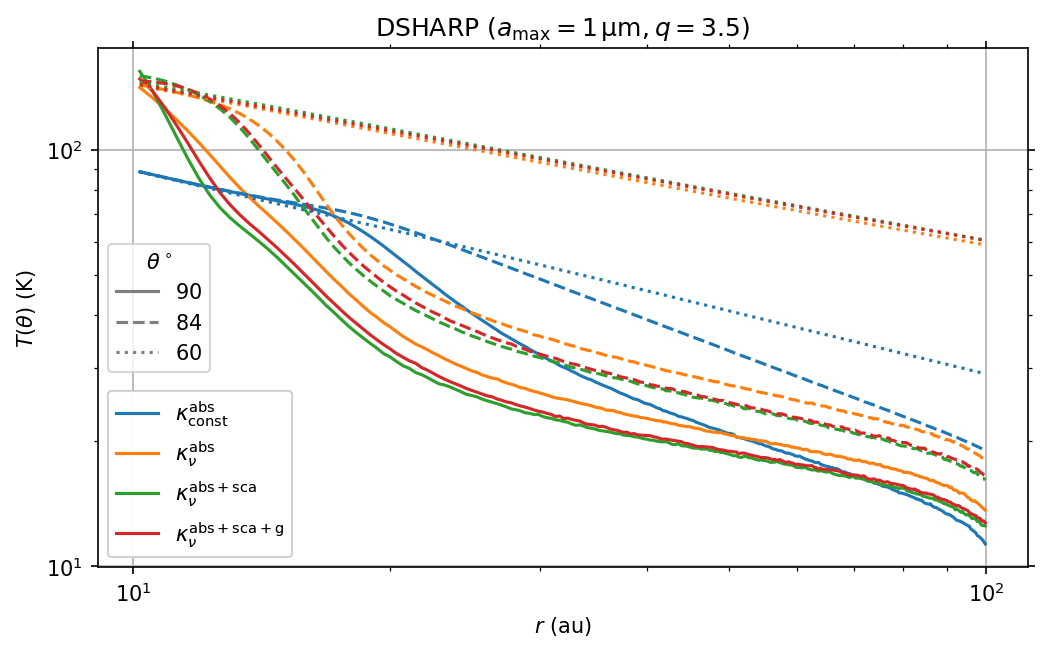

In [20]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions
rad2deg = 180/np.pi # [deg]

# Set up plots
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)
tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 84, 60]
c_solns, ls_thetas = [], []

# Read and plot RADMC-3D solutions
const = np.load('dust_temperature_const.npz')
k_abs = np.load('dust_temperature_abs.npz')
k_abs_sca = np.load('dust_temperature_abs-sca.npz')
data = analyze.readData(ddens=True, dtemp=True)
dtheta = (data.grid.yi[-1] - data.grid.yi[0])/data.grid.ny

for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(data.grid.x/natconst.au, const['dusttemp'][:,j,0,0], 'tab:blue',
            ls=lss[th])
    ax.plot(data.grid.x/natconst.au, k_abs['dusttemp'][:,j,0,0], 'tab:orange',
            ls=lss[th])
    ax.plot(data.grid.x/natconst.au, k_abs_sca['dusttemp'][:,j,0,0], 'tab:green',
            ls=lss[th])
    ax.plot(data.grid.x/natconst.au, data.dusttemp[:,j,0,0], 'tab:red',
            ls=lss[th])
    ls_thetas.append(ax.plot([], [], color='tab:gray', ls=lss[th],
                     label=rf'${theta_deg}$')[0])

# Plot ghost points for colorless line style and add legends
c_solns.append(ax.plot([], [], color='tab:blue',
               label=r'$\kappa_\mathrm{const}^\mathrm{abs}$')[0])
c_solns.append(ax.plot([], [], color='tab:orange',
               label=r'$\kappa_\nu^\mathrm{abs}$')[0])
c_solns.append(ax.plot([], [], color='tab:green',
               label=r'$\kappa_\nu^\mathrm{abs+sca}$')[0])
c_solns.append(ax.plot([], [], color='tab:red',
               label=r'$\kappa_\nu^\mathrm{abs+sca+g}$')[0])
ls_legend = plt.legend(title=r'$\theta^\circ$', handles=ls_thetas,
                       loc='center left')
color_legend = plt.legend(handles=c_solns, loc='lower left')
ax.add_artist(ls_legend)
ax.add_artist(color_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xscale='log', yscale='log', xlabel=r'$r$ (au)', ylabel=r'$T(\theta)$ (K)',
       title=r'DSHARP ($a_\mathrm{max}=1\,\mathrm{\mu m}, q=3.5$)')
ax.tick_params(axis='both', which='both', top=True, right=True)

## Tabled

In [ ]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import analyze # execute cell twice
from radmc3dPy.natconst import *

# Plot absorption coefficient as a function of wavelength
opac   = analyze.readOpac(ext=['dsharp_extrapolate']) #https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_rmcpy/radmc3dPy.html?highlight=radmc3ddustopac#radmc3dPy.dustopac.radmc3dDustOpac
figsize = (4, 3)
# figsize = (8, 4.5)
fig, ax = plt.subplots(figsize=figsize, dpi=150)

ax.plot(opac.wav[0], opac.kabs[0], label=r'$\kappa_\nu^\mathrm{abs}$')
ax.plot(opac.wav[0], opac.ksca[0], label=r'$\kappa_\nu^\mathrm{sca}$')
ax.grid()
ax.legend()
ax.minorticks_on()
ax.set(xscale='log', yscale='log', xlabel=r'$\mathrm{\lambda}$ ($\mathrm{\mu}$m)',
       ylabel=r'$\kappa_\nu$ (cm$^2$ g$^{-1}$)',
       title=r'Force extrapolation')